# Download dataset

Note: If you cannnot download using gdown, consider download manually and mount it to your colab

```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```


In [1]:
#https://drive.google.com/file/d/124q1dlt2_fBBxr5JQW27Js2lBQ6Ql9zS/view?usp=sharing
!gdown --id 124q1dlt2_fBBxr5JQW27Js2lBQ6Ql9zS

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=124q1dlt2_fBBxr5JQW27Js2lBQ6Ql9zS
From (redirected): https://drive.google.com/uc?id=124q1dlt2_fBBxr5JQW27Js2lBQ6Ql9zS&confirm=t&uuid=dd825b13-1852-4d45-a7c7-7ebb15a0fbd0
To: /content/vqa_coco_dataset.zip
100% 196M/196M [00:01<00:00, 142MB/s]


In [2]:
!unzip -q vqa_coco_dataset.zip

# Import libraries


In [3]:
!pip install timm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 414.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.8 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torchtext
import os
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms
from transformers import ViTModel, ViTImageProcessor
from transformers import AutoTokenizer, RobertaModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [5]:
train_data = []
train_set_path = './vaq2.0.TrainImages.txt'

with open(train_set_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }

        train_data.append(data_sample)

df_train = pd.DataFrame(train_data)
df_train.head()

,image_path,question,answer
0,COCO_val2014_000000393225.jpg,Is this a creamy soup ?,no
1,COCO_val2014_000000393243.jpg,Is this person wearing a tie ?,no
2,COCO_val2014_000000262197.jpg,Is this a hospital ?,yes
3,COCO_val2014_000000393277.jpg,Are there any tour buses ?,no
4,COCO_val2014_000000393277.jpg,Is this a one way street ?,no


In [6]:
val_data = []
val_set_path = './vaq2.0.DevImages.txt'

with open(val_set_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }

        val_data.append(data_sample)

df_val = pd.DataFrame(val_data)
df_val.head()

,image_path,question,answer
0,COCO_val2014_000000262175.jpg,Is this a designer tie ?,no
1,COCO_val2014_000000393284.jpg,Is this man snowboarding ?,yes
2,COCO_val2014_000000000133.jpg,Is this a child room ?,yes
3,COCO_val2014_000000000133.jpg,Could this be child room ?,yes
4,COCO_val2014_000000240323.jpg,Is this a vegetarian meal ?,no


In [7]:
test_data = []
test_set_path = './vaq2.0.TestImages.txt'

with open(test_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        test_data.append(data_sample)
df_test = pd.DataFrame(test_data)
df_test.head()

,image_path,question,answer
0,COCO_val2014_000000262162.jpg,Are there any boxes in the room ?,no
1,COCO_val2014_000000393277.jpg,Are there any any tour buses ?,no
2,COCO_val2014_000000393284.jpg,Is this person flying ?,no
3,COCO_val2014_000000262376.jpg,Is this a big building ?,yes
4,COCO_val2014_000000524611.jpg,Could this be parking lot for bikes ?,no


In [8]:
classes = set([sample['answer'] for sample in train_data])
classes_to_idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx_to_classes = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}
print(idx_to_classes)

{0: 'no', 1: 'yes'}


# Create Pytorch dataset

In [9]:
class VQADataset(Dataset):
    def __init__(self, data, classes_to_idx, img_feature_extractor, text_tokenizer, device, root_dir='./val2014-resised/'):
        self.data = data
        self.root_dir = root_dir
        self.classes_to_idx = classes_to_idx
        self.img_feature_extractor = img_feature_extractor
        self.text_tokenizer = text_tokenizer
        self.device = device

    def __len__(self):
        return len(self.data)

    def  __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')
        if self.img_feature_extractor:
            img = self.img_feature_extractor(img, return_tensors="pt")
            img = {k: v.to(self.device).squeeze(0) for k, v in img.items()}

        question = self.data[index]['question']
        if self.text_tokenizer:
            question = self.text_tokenizer(
                question,
                padding="max_length",
                max_length=20,
                truncation=True,
                return_tensors="pt"
            )
            question = {k: v.to(self.device).squeeze(0) for k, v in question.items()}


        label = self.data[index]['answer']
        label = torch.tensor(
            classes_to_idx[label],
            dtype=torch.long
        ).to(device)

        sample = {
            'image': img,
            'question': question,
            'label': label
        }


        return sample

In [10]:
img_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
text_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = VQADataset(train_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)
val_dataset = VQADataset(val_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)
test_dataset = VQADataset(test_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [11]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

# Create Model

In [12]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = ViTModel.from_pretrained("google/vit-base-patch16-224")

    def forward(self, inputs):
        outputs = self.model(**inputs)

        return outputs.pooler_output

In [13]:
class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = RobertaModel.from_pretrained("roberta-base")

    def forward(self, inputs):
        outputs = self.model(**inputs)

        return outputs.pooler_output

In [14]:
class Classifier(nn.Module):
    def __init__(self, input_size=768*2, hidden_size=512, n_layers=1, dropout_prob=0.2, n_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size*2, n_classes)

    def forward(self,x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc1(x)

        return x

In [15]:
class VQAModel(nn.Module):
    def __init__(self, visual_encoder, text_encoder, classifier):
        super().__init__()
        self.visual_encoder = visual_encoder
        self.text_encoder = text_encoder
        self.classifier = classifier

    def forward(self, image, answer):
        text_out = self.text_encoder(answer)
        image_out = self.visual_encoder(image)
        x = torch.cat((text_out, image_out), dim=1)
        x = self.classifier(x)

        return x

    def freeze(self, visual=True, textual=True, clas=False):
        if visual:
            for n,p in self.visual_encoder.named_parameters():
                p.requires_grad = False
        if textual:
            for n,p in self.text_encoder.named_parameters():
                p.requires_grad = False
        if clas:
            for n,p in self.classifier.named_parameters():
                p.requires_grad = False

In [16]:
n_classes = len(classes)
hidden_size = 1024
n_layers = 1
dropout_prob = 0.2

text_encoder = TextEncoder().to(device)
visual_encoder = VisualEncoder().to(device)
classifier = Classifier(
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob,
    n_classes=n_classes
).to(device)

model = VQAModel(
    visual_encoder=visual_encoder,
    text_encoder=text_encoder,
    classifier=classifier
).to(device)
model.freeze()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
inputs = next(iter(train_loader))

model.eval()
with torch.no_grad():
    image = inputs['image']
    question = inputs['question']
    output = model(image, question)
    print(output.shape)

torch.Size([256, 2])


# Training

In [22]:
def evaluate(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for idx, inputs in enumerate(dataloader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [23]:
def fit(model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, inputs in enumerate(train_loader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses

In [24]:
lr = 1e-2
epochs = 50
scheduler_step_size = epochs * 0.6
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [25]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
)

EPOCH 1:	Train loss: 1.3194	Val loss: 0.7209	Val Acc: 0.5343237704918032
EPOCH 2:	Train loss: 0.7136	Val loss: 0.7141	Val Acc: 0.4641393442622951
EPOCH 3:	Train loss: 0.7012	Val loss: 0.7352	Val Acc: 0.46260245901639346
EPOCH 4:	Train loss: 0.7002	Val loss: 0.8735	Val Acc: 0.4641393442622951
EPOCH 5:	Train loss: 0.7258	Val loss: 0.6989	Val Acc: 0.5496926229508197
EPOCH 6:	Train loss: 0.7001	Val loss: 0.7465	Val Acc: 0.5409836065573771
EPOCH 7:	Train loss: 0.6898	Val loss: 0.7921	Val Acc: 0.4723360655737705
EPOCH 8:	Train loss: 0.7172	Val loss: 0.7089	Val Acc: 0.5625
EPOCH 9:	Train loss: 0.6668	Val loss: 0.6861	Val Acc: 0.5732581967213115
EPOCH 10:	Train loss: 0.6463	Val loss: 0.6712	Val Acc: 0.6019467213114754
EPOCH 11:	Train loss: 0.6476	Val loss: 0.6921	Val Acc: 0.569672131147541
EPOCH 12:	Train loss: 0.6515	Val loss: 0.7384	Val Acc: 0.5635245901639344
EPOCH 13:	Train loss: 0.6536	Val loss: 0.8460	Val Acc: 0.4800204918032787
EPOCH 14:	Train loss: 0.6232	Val loss: 0.6528	Val Acc: 0.62

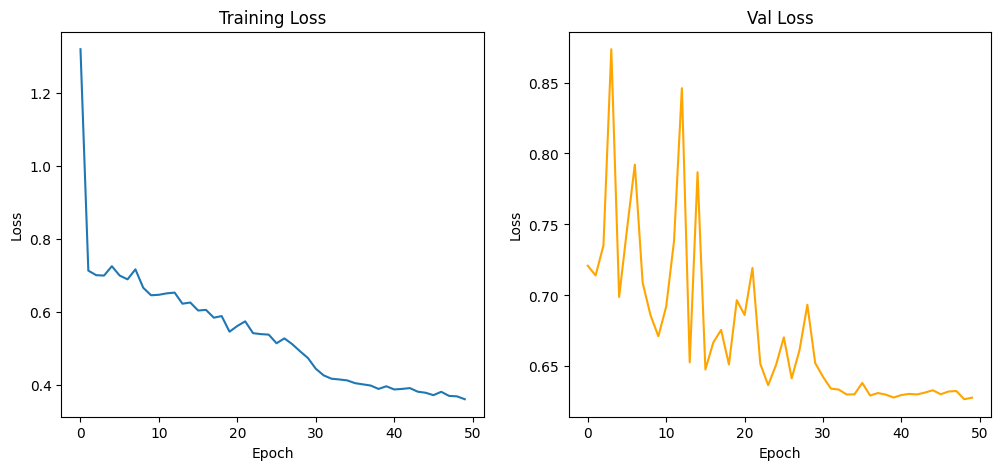

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

# Evaluation

In [27]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.6987704918032787
Test accuracy:  0.6839762611275965
